In [1]:
from matplotlib import pyplot as plt, image as mpimg
from matplotlib.gridspec import GridSpecFromSubplotSpec 
import numpy as np
import tensorflow as tf
import logging
import os
import time
from experiments import experiments
from methods import get_samples_and_labels, make_stratified_splits, make_lookup_table, load_and_preprocess_image
from models import make_augmentation
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from typing import List, Dict

tf.get_logger().setLevel(logging.ERROR)

# Global environment initialization

In [2]:
CLASS_NAMES = []
NUM_CLASSES = []
NUM_SAMPLES = []
NUM_SAMPLES_PER_CLASS = []
SAMPLES_PER_CLASS_TRAIN = []
SAMPLES_PER_CLASS_VAL = []
SAMPLES_PER_CLASS_TEST = []
TRAIN_SIZE = [] 
VAL_SIZE = []
TEST_SIZE = []
CLASS_TO_IDX_TABLE: List[tf.lookup.StaticHashTable] = []
IDX_TO_CLASS_TABLE: List[tf.lookup.StaticHashTable] = []
train_datasets = []
val_datasets = []
test_datasets = []

# DO NOT RUN MULTIPLE TIMES WITHOUT RESET

In [3]:
for experiment in experiments:
    X, y = get_samples_and_labels(experiment['dataset_path'])

    CLASS_NAMES.append(sorted(set(y)))
    NUM_CLASSES.append(len(CLASS_NAMES[-1]))
    NUM_SAMPLES.append(len(X))
    NUM_SAMPLES_PER_CLASS.append(NUM_SAMPLES[-1] // NUM_CLASSES[-1])
    SAMPLES_PER_CLASS_TRAIN.append(experiment['samples_per_class_train'])
    SAMPLES_PER_CLASS_VAL.append(experiment['samples_per_class_val'])
    SAMPLES_PER_CLASS_TEST.append(NUM_SAMPLES_PER_CLASS[-1] - SAMPLES_PER_CLASS_TRAIN[-1] - SAMPLES_PER_CLASS_VAL[-1])
    TRAIN_SIZE.append(SAMPLES_PER_CLASS_TRAIN[-1] * NUM_CLASSES[-1])
    VAL_SIZE.append(SAMPLES_PER_CLASS_VAL[-1] * NUM_CLASSES[-1])
    TEST_SIZE.append(NUM_SAMPLES[-1] - TRAIN_SIZE[-1] - VAL_SIZE[-1])
    keys_to_vals, vals_to_keys = make_lookup_table(CLASS_NAMES[-1])
    CLASS_TO_IDX_TABLE.append(keys_to_vals)
    IDX_TO_CLASS_TABLE.append(vals_to_keys)

    assert TRAIN_SIZE[-1] + VAL_SIZE[-1] <= NUM_SAMPLES[-1], "Not enough samples for the specified train/val split."

    train_dataset, val_dataset, test_dataset = make_stratified_splits(X, y, VAL_SIZE[-1], TEST_SIZE[-1])
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)

# Models initialization - run following block to reset trained models

In [4]:
models: List[tf.keras.Sequential] = []
histories = []
test_results = []
stop_epochs = []
y_preds = []
y_true_classes = []
for i, experiment in enumerate(experiments):
    models.append(experiment['model_gen'](experiment['input_shape'], NUM_CLASSES[i], experiment['learning_rate'], experiment['dropout_rate']))

In [5]:
for i, experiment in enumerate(experiments):
    print(f"Starting experiment {i+1}/{len(experiments)}: {experiment['name']}")
    models[i].summary()
    print()

Starting experiment 1/4: szsz
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)            

# Training loop - run following block to conduct experiments

In [6]:
for i, experiment in enumerate(experiments):
    print(f"Starting experiment {i+1}/{len(experiments)}: {experiment['name']}")

    augmentation = make_augmentation(experiment['rotation_factor'], experiment['zoom_factor'], experiment['translation_factor'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, min_delta=0.001)

    train_dataset = train_datasets[i].map(lambda path, label: (load_and_preprocess_image(path, label, CLASS_TO_IDX_TABLE[i], experiment['input_shape'], NUM_CLASSES[i])))
    train_dataset = train_dataset.batch(experiment['batch_size']).shuffle(reshuffle_each_iteration=True, buffer_size=train_dataset.cardinality()).cache().map(
        lambda x, y: (augmentation(x), y) , num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE
    )

    val_dataset = val_datasets[i].map(lambda path, label: (load_and_preprocess_image(path, label, CLASS_TO_IDX_TABLE[i], experiment['input_shape'], NUM_CLASSES[i])))
    val_dataset = val_dataset.batch(experiment['batch_size']).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    histories.append(
        models[i].fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=experiment['epochs'],
            callbacks=[callback]
        )
    )

    stop_epochs.append(callback.stopped_epoch)

    if TEST_SIZE[i] > 0:
        test_dataset = test_datasets[i].map(lambda path, label: (load_and_preprocess_image(path, label, CLASS_TO_IDX_TABLE[i], experiment['input_shape'], NUM_CLASSES[i])))
        y_true_classes.append(tf.argmax([y for _, y in test_dataset], axis=1))
        test_dataset = test_dataset.batch(experiment['batch_size']).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        restults = models[i].evaluate(test_dataset)
        test_results.append(restults)
        y_pred_pobs = models[i].predict(test_dataset)
        y_pred =tf.argmax(y_pred_pobs, axis=1)
        y_preds.append(y_pred)

    print()

Starting experiment 1/4: szsz
Epoch 1/100


C:\Users\jszedel\anaconda3\envs\tf-gpu-se-01\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 4s 92ms/step - loss: 2.8459 - accuracy: 0.0741 - val_loss: 2.7338 - val_accuracy: 0.0667
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 2.7137 - accuracy: 0.0444 - val_loss: 2.7071 - val_accuracy: 0.0667
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 2.7082 - accuracy: 0.0667 - val_loss: 2.6841 - val_accuracy: 0.0667
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 2.6305 - accuracy: 0.1407 - val_loss: 2.6254 - val_accuracy: 0.1333
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 2.5960 - accuracy: 0.1407 - val_loss: 2.5536 - val_accuracy: 0.2333
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 2.5156 - accuracy: 0.2074 - val_loss: 2.4278 - val_accuracy: 0.4333
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 2.3803 - accuracy: 0.3926 - val_loss: 2.2064 - val_accuracy: 0.6000
Epoch 8/100
5/5 [=====================

Experiment 1: szsz
  Dataset Path: ./datasets/sensors-2026-freehand/as-captured/szsz
  Number of Classes: 15
  Total Samples: 225
  Samples per Class: 15
  Training Samples: 135 (9 per class)
  Validation Samples: 30 (2 per class)
  Testing Samples: 60 (4 per class)
  Class Names: ['ALPR', 'ALPV', 'CUxx', 'FING', 'HLOW', 'OWN1', 'OWN2', 'OWN3', 'OWN4', 'OWN5', 'PUxx', 'SIGM', 'SPIR', 'TUxx', 'WUxx']
  Epochs: 100, Stopped at epoch: 49
  Rotation Factor: 0.1, Zoom Factor: 0.1, Translation Factor: 0.1
  Learning Rate: 0.001, Dropout Rate: 0.5

Training: loss min: 0.03712145611643791 , accuracy max: 1.0
Validation: loss min: 0.0011835350887849927 , accuracy max: 1.0
Test results: loss 0.24981220066547394 , accuracy: 0.949999988079071


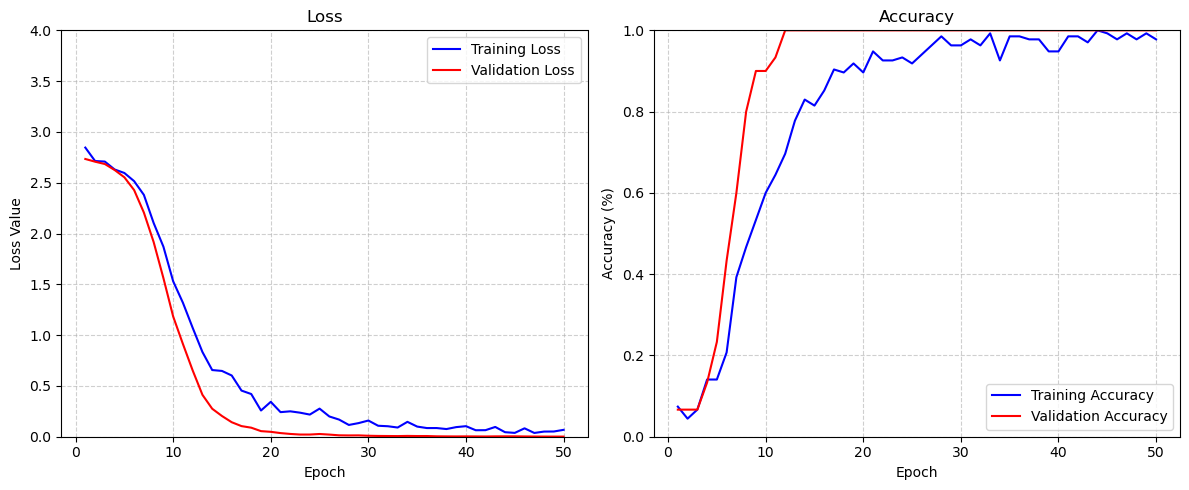


Experiment 2: szsz
  Dataset Path: ./datasets/sensors-2026-freehand/as-captured/szsz
  Number of Classes: 15
  Total Samples: 225
  Samples per Class: 15
  Training Samples: 135 (9 per class)
  Validation Samples: 30 (2 per class)
  Testing Samples: 60 (4 per class)
  Class Names: ['ALPR', 'ALPV', 'CUxx', 'FING', 'HLOW', 'OWN1', 'OWN2', 'OWN3', 'OWN4', 'OWN5', 'PUxx', 'SIGM', 'SPIR', 'TUxx', 'WUxx']
  Epochs: 100, Stopped at epoch: 42
  Rotation Factor: 0.1, Zoom Factor: 0.1, Translation Factor: 0.1
  Learning Rate: 0.001, Dropout Rate: 0.5

Training: loss min: 0.20130625367164612 , accuracy max: 0.9555555582046509
Validation: loss min: 0.024715745821595192 , accuracy max: 1.0
Test results: loss 0.2178746908903122 , accuracy: 0.9333333373069763


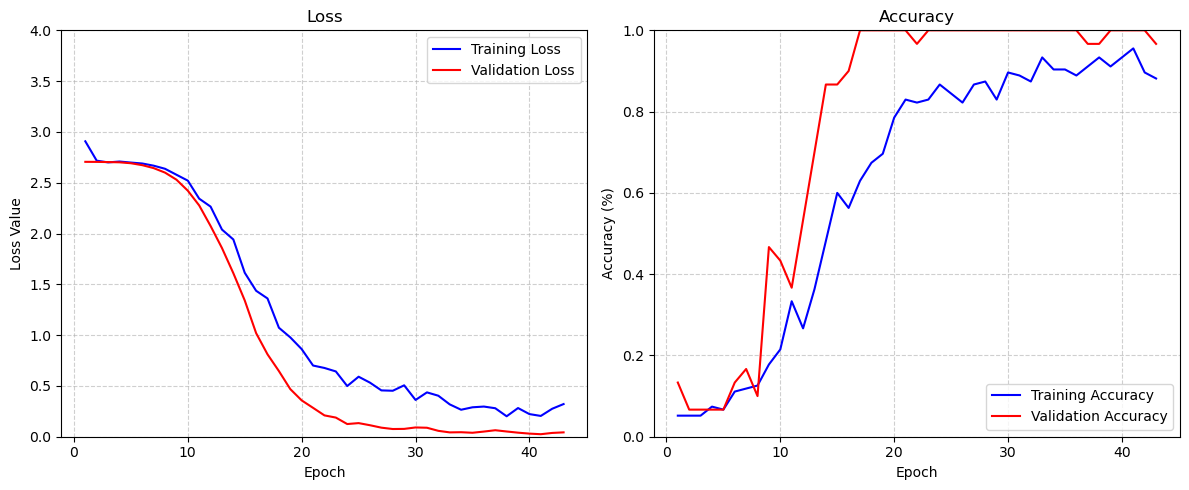


Experiment 3: jasz
  Dataset Path: ./datasets/sensors-2026-freehand/as-captured/jasz
  Number of Classes: 15
  Total Samples: 225
  Samples per Class: 15
  Training Samples: 135 (9 per class)
  Validation Samples: 30 (2 per class)
  Testing Samples: 60 (4 per class)
  Class Names: ['ALPR', 'ALPV', 'CUxx', 'FING', 'HLOW', 'OWN1', 'OWN2', 'OWN3', 'OWN4', 'OWN5', 'PUxx', 'SIGM', 'SPIR', 'TUxx', 'WUxx']
  Epochs: 100, Stopped at epoch: 33
  Rotation Factor: 0.1, Zoom Factor: 0.1, Translation Factor: 0.1
  Learning Rate: 0.001, Dropout Rate: 0.5

Training: loss min: 0.2327258437871933 , accuracy max: 0.9629629850387573
Validation: loss min: 0.302444726228714 , accuracy max: 0.9333333373069763
Test results: loss 0.7427289485931396 , accuracy: 0.8333333134651184


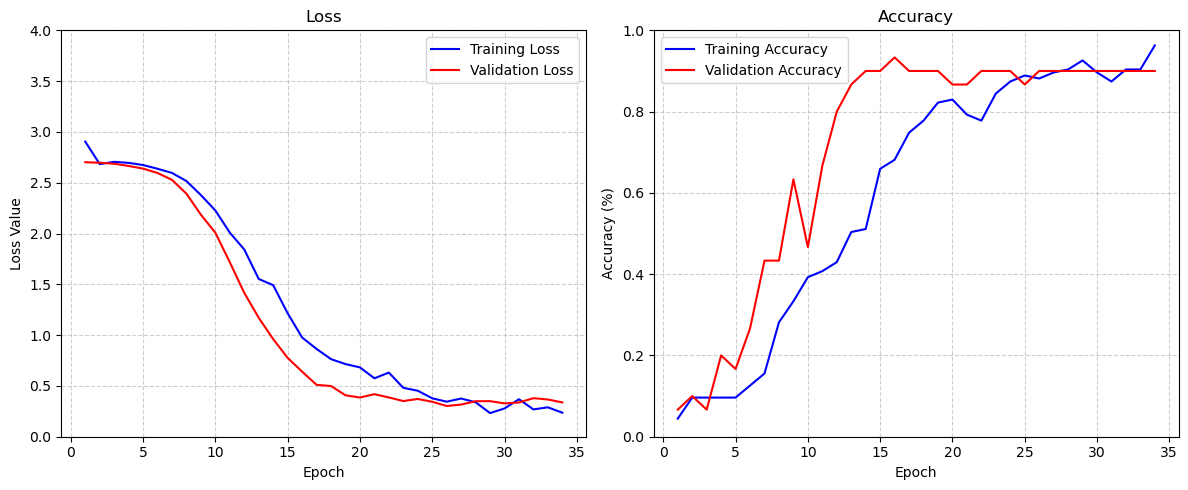


Experiment 4: jasz
  Dataset Path: ./datasets/sensors-2026-freehand/as-captured/jasz
  Number of Classes: 15
  Total Samples: 225
  Samples per Class: 15
  Training Samples: 135 (9 per class)
  Validation Samples: 30 (2 per class)
  Testing Samples: 60 (4 per class)
  Class Names: ['ALPR', 'ALPV', 'CUxx', 'FING', 'HLOW', 'OWN1', 'OWN2', 'OWN3', 'OWN4', 'OWN5', 'PUxx', 'SIGM', 'SPIR', 'TUxx', 'WUxx']
  Epochs: 100, Stopped at epoch: 61
  Rotation Factor: 0.1, Zoom Factor: 0.1, Translation Factor: 0.1
  Learning Rate: 0.001, Dropout Rate: 0.5

Training: loss min: 0.10058137029409409 , accuracy max: 0.9851852059364319
Validation: loss min: 0.21029876172542572 , accuracy max: 0.9333333373069763
Test results: loss 0.6896962523460388 , accuracy: 0.8500000238418579


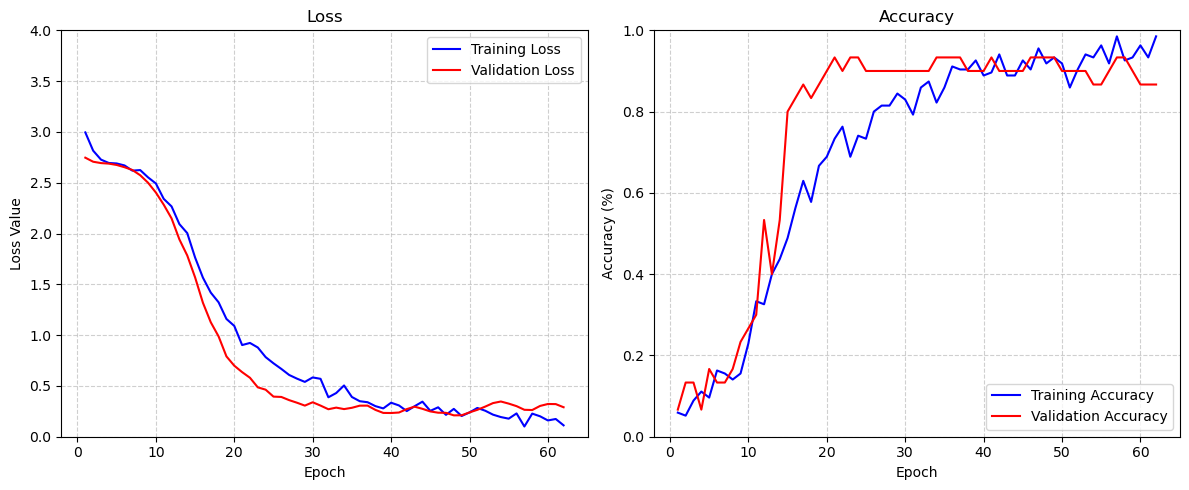

In [7]:
for i, history in enumerate(histories):
    print(f"Experiment {i+1}: {experiments[i]['name']}")
    print(f"  Dataset Path: {experiments[i]['dataset_path']}")
    print(f"  Number of Classes: {NUM_CLASSES[i]}")
    print(f"  Total Samples: {NUM_SAMPLES[i]}")
    print(f"  Samples per Class: {NUM_SAMPLES_PER_CLASS[i]}")
    print(f"  Training Samples: {TRAIN_SIZE[i]} ({SAMPLES_PER_CLASS_TRAIN[i]} per class)")
    print(f"  Validation Samples: {VAL_SIZE[i]} ({SAMPLES_PER_CLASS_VAL[i]} per class)")
    print(f"  Testing Samples: {TEST_SIZE[i]} ({SAMPLES_PER_CLASS_TEST[i]} per class)")
    print(f"  Class Names: {CLASS_NAMES[i]}")
    print(f"  Epochs: {experiments[i]['epochs']}, Stopped at epoch: {stop_epochs[i]}")
    print(f"  Rotation Factor: {experiments[i]['rotation_factor']}, Zoom Factor: {experiments[i]['zoom_factor']}, Translation Factor: {experiments[i]['translation_factor']}")
    print(f"  Learning Rate: {experiments[i]['learning_rate']}, Dropout Rate: {experiments[i]['dropout_rate']}")
    print()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(history.history['loss']) + 1)

    print("Training: loss min:", np.min(loss), ", accuracy max:", np.max(accuracy))
    print("Validation: loss min:", np.min(val_loss), ", accuracy max:", np.max(val_accuracy))
    print("Test results: loss", test_results[i][0], ", accuracy:", test_results[i][1] if TEST_SIZE[i] > 0 else "No test set")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis(ymin=0, ymax=4)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis(ymin=0, ymax=1)

    plt.tight_layout()
    plt.show()

    print()

# Confusion matrices

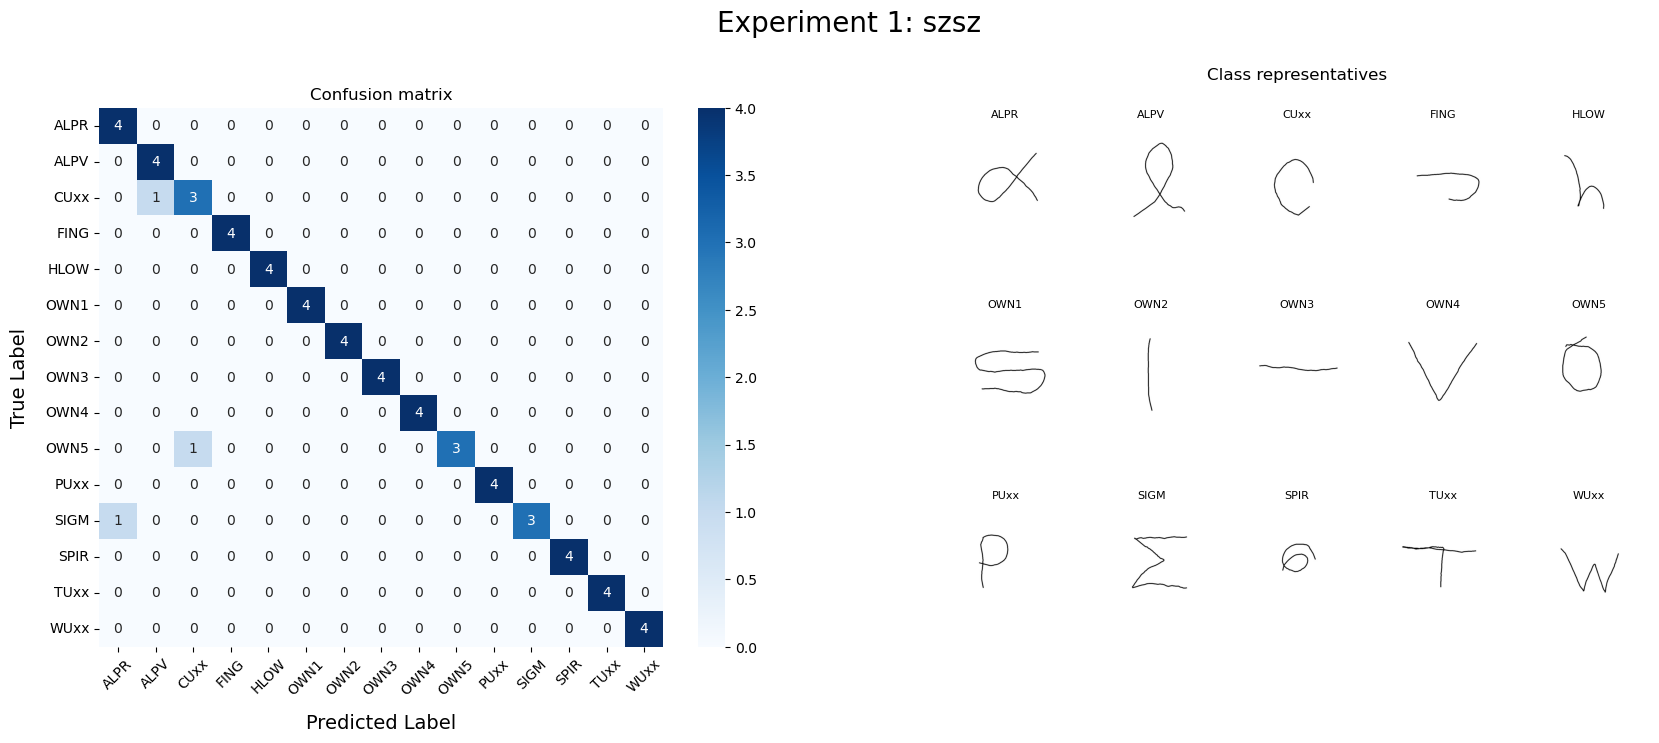

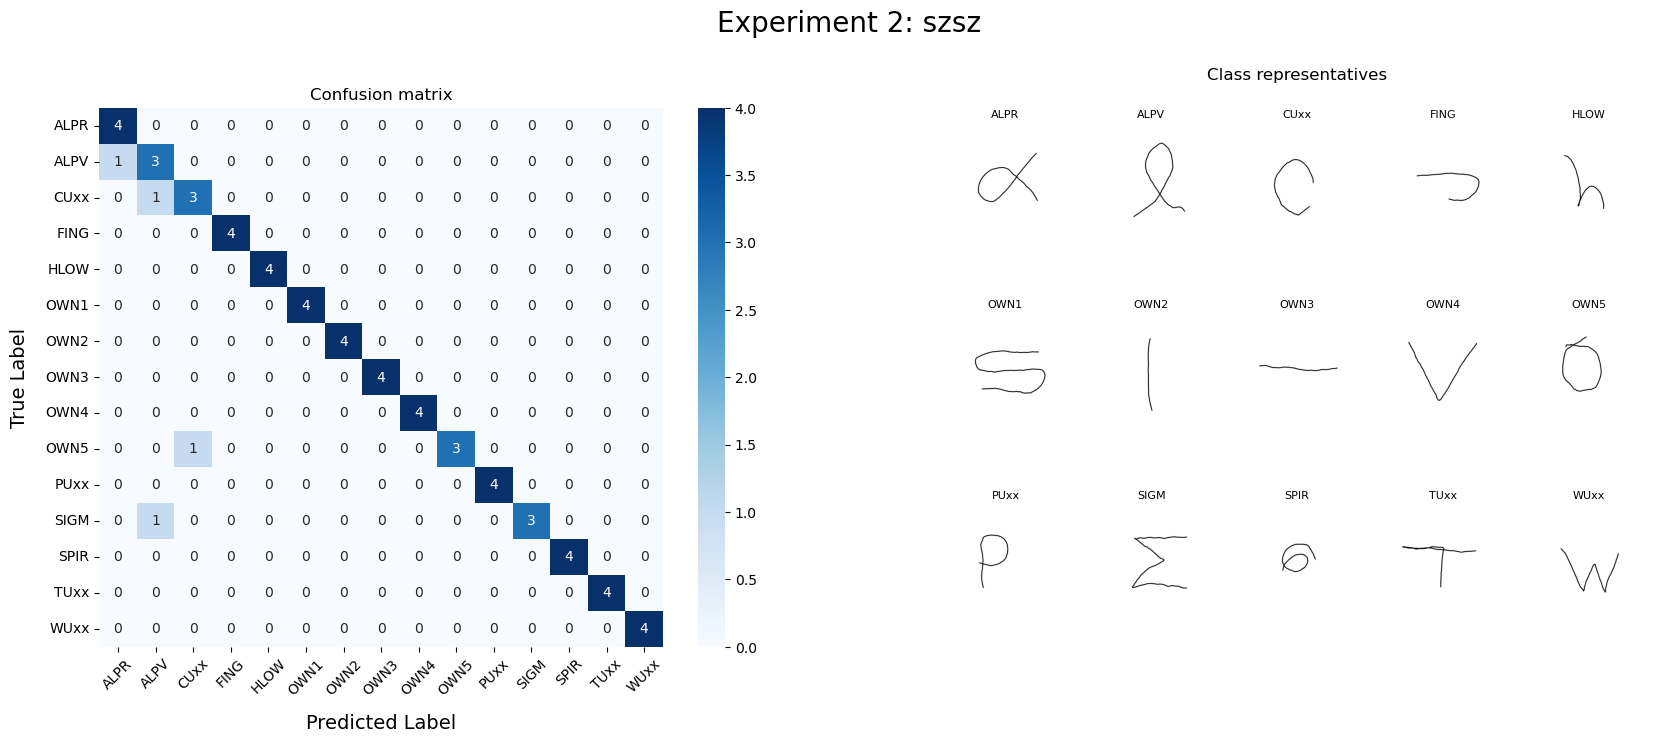

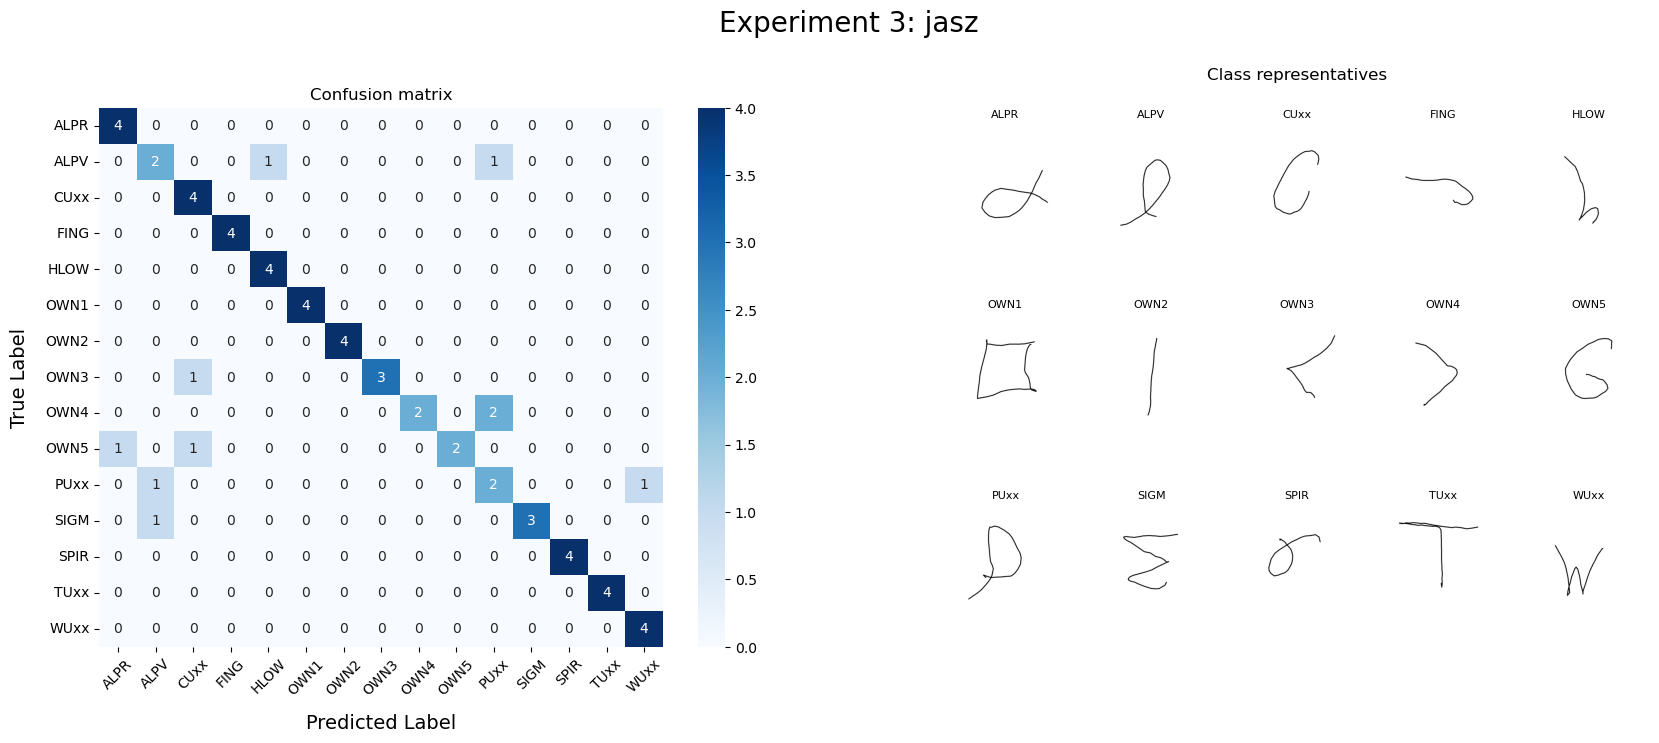

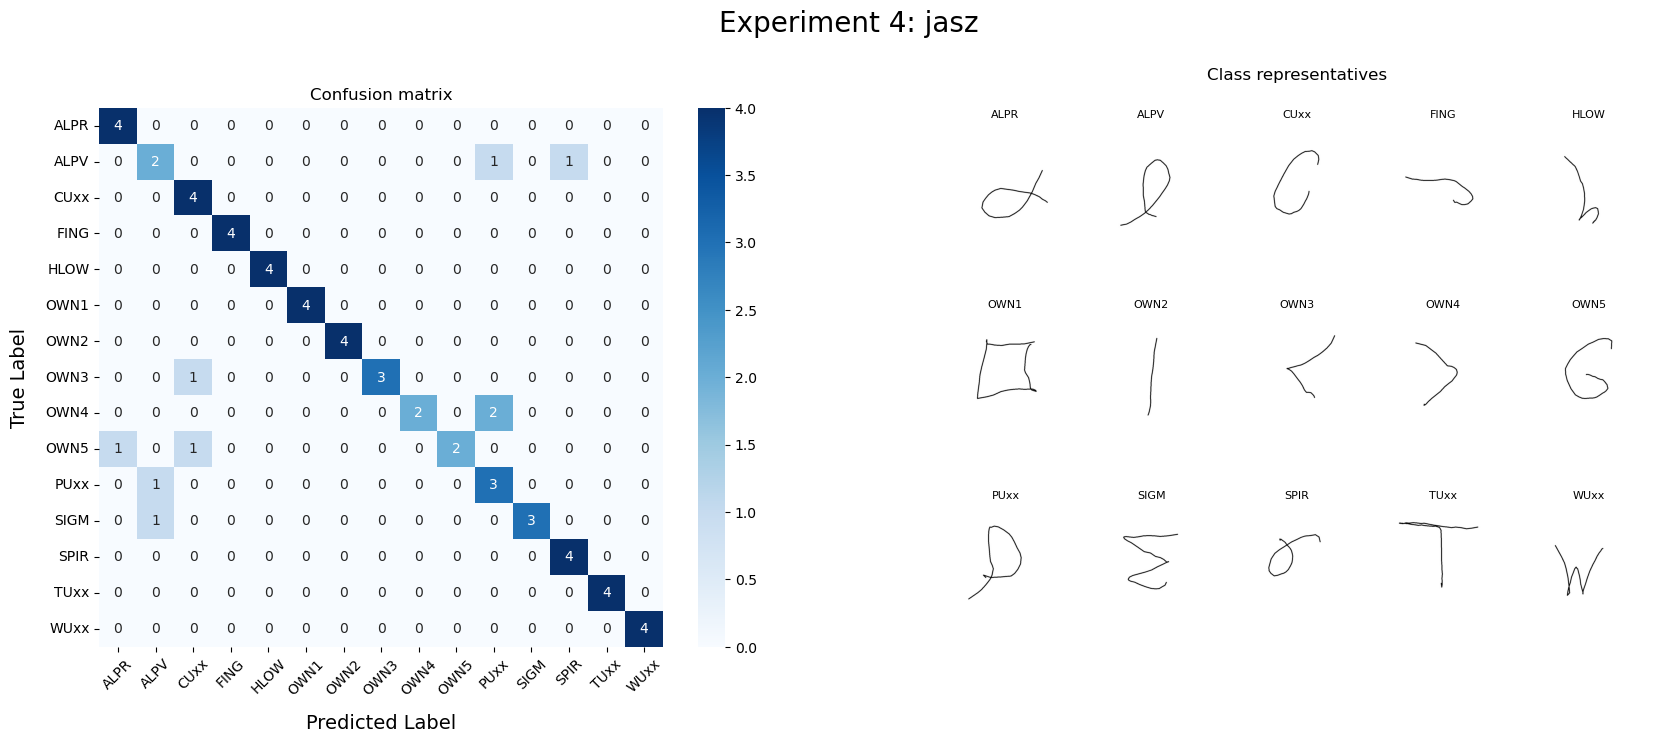

In [8]:
for i, experiment in enumerate(experiments):
    representatives = {y.numpy().decode('utf-8'): x.numpy().decode('utf-8') for x, y in test_datasets[i]}
    cm = confusion_matrix(y_true_classes[i].numpy(), y_preds[i].numpy())
    labels = list(map(lambda x: x.decode('utf-8'), IDX_TO_CLASS_TABLE[i].lookup(tf.constant([j for j in range(NUM_CLASSES[i])], dtype=tf.int64)).numpy()))
    images = [mpimg.imread(representatives[label]) for label in labels]
    

    fig = plt.figure(figsize=(20, 7))
    main_grid = fig.add_gridspec(1, 2)
    heatmap_axis = fig.add_subplot(main_grid[0, 0])

    hm = heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    hm.set_ylabel('True Label', fontdict={'fontsize':14}, labelpad=12)
    hm.set_xlabel('Predicted Label', fontdict={'fontsize':14}, labelpad=12)
    heatmap_axis.set_title('Confusion matrix')
    heatmap_axis.set_xlabel('Predicted Label')
    heatmap_axis.set_ylabel('True Label')
    heatmap_axis.set_xticklabels(labels, rotation=45)

    images_container_axis = fig.add_subplot(main_grid[0, 1])
    images_container_axis.axis('off')
    images_container_axis.set_title('Class representatives', pad=20)
    images_grid = GridSpecFromSubplotSpec(3, 5, subplot_spec=main_grid[0, 1])
    for j in range(len(labels)):
        image_axis = fig.add_subplot(images_grid[j])
        image_axis.imshow(images[j])
        image_axis.set_title(labels[j], fontsize=8)
        image_axis.axis('off')

    fig.suptitle(f'Experiment {i+1}: {experiment["name"]}', fontsize=20, y=1.02)

    plt.show()


# Following block is used to save choosen experiments metrics

In [9]:
experiments_to_save = [] # Indices of experiments to save metrics for

for experiment in experiments_to_save:
    experiment_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
    name = experiments[experiment].get('name', None)
    if name != None:
        name = f"{experiments[experiment]['name']}_{experiment_time}"
    else:
        name = f"{experiment_time}"
    
    os.makedirs(f"./metrics/{name}", exist_ok=True)
    np.savetxt(f"./metrics/{name}/loss.csv", histories[experiment].history['loss'], delimiter=",")
    np.savetxt(f"./metrics/{name}/val_loss.csv", histories[experiment].history['val_loss'], delimiter=",")
    np.savetxt(f"./metrics/{name}/accuracy.csv", histories[experiment].history['accuracy'], delimiter=",")
    np.savetxt(f"./metrics/{name}/val_accuracy.csv", histories[experiment].history['val_accuracy'], delimiter=",")
    if TEST_SIZE[experiment] > 0:
        np.savetxt(f"./metrics/{name}/test_results.csv", test_results[experiment], delimiter=",")
    
    time.sleep(1)  # Ensure unique timestamps for directory names